<a href="https://colab.research.google.com/github/victorsergio/GNN-trajectory-prediction-2023/blob/main/sac_graph_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Oct 31 15:14:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

# Load clustered dataset
dataframe = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train.csv', sep=',')

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

dataframe_scaled = dataframe[["x", "y", "vx", "vy","psi_rad"]]
dataframe = dataframe.drop(columns=["x", "y", "vx", "vy","psi_rad"], axis=1)

scaler = MinMaxScaler()
dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe_scaled), columns=["x", "y", "vx", "vy","psi_rad"])

dataframe = pd.concat([dataframe, dataframe_scaled], axis=1)

# Save scaler to file
import pickle as pkl
with open("/content/drive/My Drive/PHD_2022/Latincom_2022/models/graph-75/graph_train_scaler_75.pkl", "wb") as outfile:
    pkl.dump(scaler, outfile)


In [ ]:
case_id = dataframe.groupby(["case_id", "label"])

scenary_x = []
scenary_y = []



for ix,element in case_id:
    l = element.groupby(["track_id"])
    
    agents = [] # 5 trajectories (scenary), one per agent

    # Get 5 scenary trajectories
    for ig, eg in l:
        feat = eg[["x", "y", "vx", "vy","psi_rad"]]
        f_list = feat.values.tolist()
        agents.append(f_list)
    
    # separate each trajectory
    a = np.array(agents[0])
    b = np.array(agents[1])
    c = np.array(agents[2])
    d = np.array(agents[3])
    e = np.array(agents[4])
    #f = np.array(agents[5])
    #g = np.array(agents[6])
    #h = np.array(agents[7])
    #i = np.array(agents[8])


    # split
    a_x = a[0:10,:]
    a_y = a[10:,:] 

    b_x = b[0:10,:]
    b_y = b[10:,:] 
    
    c_x = c[0:10,:]
    c_y = c[10:,:] 

    d_x = d[0:10,:]
    d_y = d[10:,:] 

    e_x = e[0:10,:]
    e_y = e[10:,:] 
    
    #f_x = f[0:10,:]
    #f_y = f[10:,:]

    #g_x = g[0:10,:]
    #g_y = g[10:,:] 

    #h_x = h[0:10,:]
    #h_y = h[10:,:] 
    
    #i_x = i[0:10,:]
    #i_y = i[10:,:]

    stack_x = np.hstack((a_x,b_x,c_x,d_x,e_x))
    stack_x = stack_x.reshape(10,5,5) # timesteps, ncars, 5 features

    stack_y = np.hstack((a_y,b_y,c_y,d_y,e_y))
    stack_y = stack_y.reshape(10,5,5) # timestesp,ncars,2 features


    #d_x = np.hstack((a_x,b_x,c_x,d_x,e_x,f_x,g_x,h_x,i_x))
    #d_x = d_x.reshape(10,9,5) # 5 features

    #d_y = np.hstack((a_y,b_y,c_y,d_y,e_y,f_y,g_y,h_y,i_y))
    #d_y = d_y.reshape(10,9,5) # 2 features


    scenary_x.append(stack_x)
    scenary_y.append(stack_y)
        
    
s1 = np.array(scenary_x)   
print(s1.shape)

s2 = np.array(scenary_y)   
print(s2.shape)



In [ ]:
scene_x = np.array(scenary_x)
scene_y = np.array(scenary_y)


In [ ]:
# split train and test set

from sklearn.model_selection import train_test_split

scene_x_train, scene_x_test, scene_y_train, scene_y_test = train_test_split(scene_x, scene_y, test_size=0.2, random_state=1)


print(scene_x_train.shape)
print(scene_y_train.shape)
print(scene_x_test.shape)
print(scene_y_test.shape)

# Store interaction groups to use in the future

scene_x_train_interaction = scene_x_train
scene_y_train_interaction = scene_y_train
scene_x_test_interaction = scene_x_test
scene_y_test_interaction = scene_y_test

(428, 10, 5, 5)
(428, 10, 5, 5)
(108, 10, 5, 5)
(108, 10, 5, 5)


In [ ]:
import typing

adjacency_matrix = np.array([[1, 1, 1], [1, 1, 1],[1, 1, 1],[1, 1, 1],[1, 1, 1]])


class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


node_indices, neighbor_indices = np.where(adjacency_matrix == 1)

graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 5, number of edges: 15


In [ ]:
# Display All Intersection
import random

def print_all_intersection(prev_list,ground_list,prediction_list,n,ix):
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]

    if prediction_list is not None:
        pred = prediction_list[ix:ix+n]
   
    fig, ax = plt.subplots(figsize=(20,20))


    for i,p in enumerate(prev):
        
        g = ground[i]

        p = tf.transpose(p,[1,0]) 
        g = tf.transpose(g,[1,0])

        ax.plot(p[0], p[1],'-o',color='gray',linestyle='dashed')
        ax.plot(g[0], g[1],'-o',color='green',linestyle='dashed')

        # to print all lines of the dataset

        #colors = ['blue','green','red','cyan','magenta','yellow','black']
        #random_color = random.randint(0, 6)

        #ax.plot(p[0], p[1],'-',color=colors[random_color],linestyle='solid')
        #ax.plot(g[0], g[1],'-',color=colors[random_color],linestyle='solid')

        # if you want to print predictions and ground truths at the same time
        if prediction_list is not None:
            r = pred[i]
            r = tf.transpose(r,[1,0])
            ax.plot(r[0], r[1],'-o',color='red',linestyle='dashed')
        
    
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Network architecture

Our model for forecasting over the graph consists of a graph convolution
layer and a LSTM layer.
"""

"""
### Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation
in [this Keras example](https://keras.io/examples/graph/gnn_citations/). Note that
in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape
`(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer
performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations and then multiplying the results by
`self.weight`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages
"""


class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


"""
### LSTM plus graph convolution

By applying the graph convolution layer to the input tensor, we get another tensor
containing the nodes' representations over time (another 4D tensor). For each time
step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors
but also we need to process the information over time. To this end, we can pass each
node's tensor through a recurrent layer. The `LSTMGC` layer below, first applies
a graph convolution layer to the inputs and then passes the results through a
`LSTM` layer.
"""


class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        
        self.encoder = layers.GRU(512, return_sequences=True)
        self.encoder_2 = layers.GRU(512, return_sequences=False)
        self.latent_vector = layers.RepeatVector(10)
        self.decoder = layers.GRU(256, return_sequences=True)
        self.decoder_2 = layers.GRU(256, return_sequences=True)
        self.decoder_last = layers.TimeDistributed(layers.Dense(units=5, activation='linear'))

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )
                                           

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        

        encoder_output = self.encoder(gcn_out)
        encoder_2_output = self.encoder_2(encoder_output)
        latent_vector_output = self.latent_vector(encoder_2_output)
        decoder_output = self.decoder(latent_vector_output)
        decoder_2_output = self.decoder_2(decoder_output)
        decoder_last_output = self.decoder_last(decoder_2_output) 

        
        output = tf.reshape(decoder_last_output, (num_nodes, batch_size, self.output_seq_len,5)) # 5 features

        return tf.transpose(output, [1, 2, 0, 3 ])
        


"""
## Model training
"""

in_feat = 5
batch_size = 32
epochs = 5
input_sequence_length = 10
forecast_horizon = 10
multi_horizon = False
out_feat = 10
lstm_units = 512

graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)



In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/My Drive/PHD_2022/Latincom_2022/models/graph-50/')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5, 5)]        0         
                                                                 
 lstmgc (LSTMGC)             (None, 10, 5, 5)          3383607   
                                                                 
Total params: 3,383,607
Trainable params: 3,383,607
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),   #original =  0.0000001
    loss=['mse'],
    metrics=['mse', 'mae']
)


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="graph-interaction-paper-ablation")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: victorsergio. Use `wandb login --relogin` to force relogin


In [ ]:
#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False,save_model=False)
# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0000000000000005, patience=30, mode='min', restore_best_weights=True) #0.00005

save_callback = mc = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/PHD_2022/Latincom_2022/models/graph/checkpoints/', save_weights_only=False, period=500)


# callbacks
callbacks_list = [wandb_callback,early_stopping_callback,save_callback]

In [ ]:
from sklearn.utils import shuffle
model.fit(
    scene_x_train, scene_y_train, 
    validation_split=0.2,
    batch_size = 128, #original 64
    epochs=10000,  #original development 1000
    shuffle = True,
    callbacks=callbacks_list,
)

In [ ]:
# saving the model in tensorflow format
model.save('/content/drive/MyDrive/PHD_2022/Latincom_2022/models/graph-50')

In [ ]:
# ADE function (single)

import math
def average_displacement_error(pred,ground):

    e = []

    for p,g in zip(pred,ground):
        e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))

    return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE

In [ ]:
# ADE function over BATCH (mean)

def calculate_error_batch(results, ground):

    ADE = []
    FDE = [] 

    for r, g in zip(results, ground):
        a,f = average_displacement_error(r,g)
        ADE.append(a)
        FDE.append(f)
    
    return np.sum(ADE)/len(ADE),np.sum(FDE)/len(FDE)


In [ ]:
# Evaluate to get MSE error
y_pred = model.evaluate(scene_x_test,scene_y_test)

4/4 [==============================] - 0s 11ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0207


In [ ]:
# Predict to get ADE and FDE metrics (Normalized)

results = model.predict(scene_x_test)
#calculate_error_batch(scene_x_train,scene_y_train)

4/4 [==============================] - 1s 10ms/step


In [ ]:
print(results.shape)
print(scene_y_test.shape)

(108, 10, 5, 5)
(108, 10, 5, 5)


In [ ]:
scene_y_test.shape

(108, 10, 5, 5)

In [ ]:
# reshape array secuence to to single agent to reuse draw and metrics functions

results_single = np.array(results)
results_single = tf.transpose(results_single, [2, 0, 1, 3 ])
results_single = np.reshape(results_single, (108*5,10,5)) #note
print(results_single.shape)


(540, 10, 5)


In [ ]:


# Split dataset to be used as single agent model predictor
scene_x_train_single = tf.transpose(scene_x_train, [2, 0, 1, 3])
scene_x_train_single = tf.reshape(scene_x_train_single, (428 * 5, 10, 5))  #batch*nodes, seq_len, feat

scene_x_test_single = tf.transpose(scene_x_test, [2, 0, 1, 3])
scene_x_test_single = tf.reshape(scene_x_test_single, (108 * 5, 10, 5))  #batch*nodes, seq_len, feat

scene_y_train_single = tf.transpose(scene_y_train, [2, 0, 1, 3])
scene_y_train_single = tf.reshape(scene_y_train_single, (428 * 5, 10, 5))  #batch*nodes, seq_len, feat

scene_y_test_single = tf.transpose(scene_y_test, [2, 0, 1, 3])
scene_y_test_single = tf.reshape(scene_y_test_single, (108 * 5, 10, 5))  #batch*nodes, seq_len, feat

print(scene_x_train_single.shape)
print(scene_y_train_single.shape)
print(scene_x_test_single.shape)
print(scene_y_test_single.shape)


(2140, 10, 5)
(2140, 10, 5)
(540, 10, 5)
(540, 10, 5)


In [ ]:
import matplotlib.pyplot as plt

# Display single trajectories

def print_single_trajectory(prev_list,ground_list,prediction_list,n,ix):
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]

    if prediction_list is not None:
        pred = prediction_list[ix:ix+n]
   
    fig, ax = plt.subplots(1,n,figsize=(20,4))


    for i,p in enumerate(prev):
        
        g = ground[i]

        p = tf.transpose(p,[1,0]) 
        g = tf.transpose(g,[1,0])

        ax[i].plot(p[0], p[1],'-o',color='gray',linestyle='dashed')
        ax[i].plot(g[0], g[1],'-o',color='green',linestyle='dashed')

        # if you want to print predictions and ground truths at the same time
        if prediction_list is not None:
            r = pred[i]
            r = tf.transpose(r,[1,0])
            ax[i].plot(r[0], r[1],'-o',color='red',linestyle='dashed')
        
    
    plt.show()


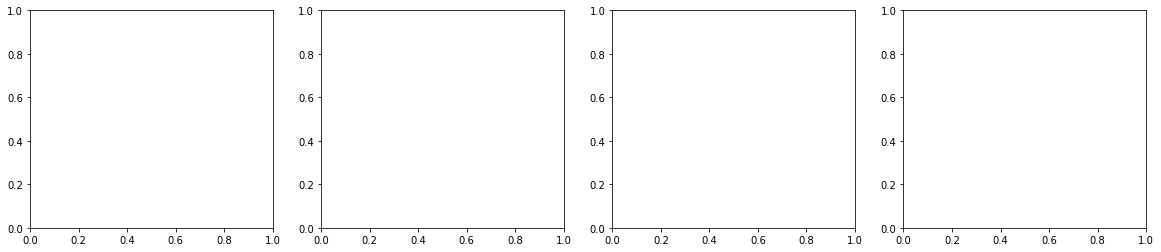

In [ ]:
print_single_trajectory(scene_x_test_single,scene_y_test_single, results_single,4,600) #30,40,50,60,70,80,200,241,251,351,461

In [ ]:
###### X TEST ######

# reshape to get a 2D array to feed the inverse scaler
reversed_scene_x_test = np.array(scene_x_test_single)
reversed_scene_x_test = reversed_scene_x_test.reshape(scene_x_test_single.shape[0]*scene_x_test_single.shape[1],scene_x_test_single.shape[2])
# Inverse transform to evaluate metrics ADE y FDE
reversed_scene_x_test = scaler.inverse_transform(reversed_scene_x_test)
# reverse reshape to get a 3d array again
reversed_scene_x_test = reversed_scene_x_test.reshape(scene_x_test_single.shape[0],scene_x_test_single.shape[1],scene_x_test_single.shape[2])
print(reversed_scene_x_test.shape)

###### Y TEST #######

# reshape to get a 2D array to feed the inverse scaler
reversed_scene_y_test = np.array(scene_y_test_single)
reversed_scene_y_test = reversed_scene_y_test.reshape(scene_y_test_single.shape[0]*scene_y_test_single.shape[1],scene_y_test_single.shape[2])
# Inverse transform to evaluate metrics ADE y FDE
reversed_scene_y_test = scaler.inverse_transform(reversed_scene_y_test)
# reverse reshape to get a 3d array again
reversed_scene_y_test = reversed_scene_y_test.reshape(scene_y_test_single.shape[0],scene_y_test_single.shape[1],scene_y_test_single.shape[2])
print(reversed_scene_y_test.shape)

(540, 10, 5)
(540, 10, 5)


In [ ]:
###### X TRAIN ######

# reshape to get a 2D array to feed the inverse scaler
reversed_scene_x_train = np.array(scene_x_train_single)
reversed_scene_x_train = reversed_scene_x_train.reshape(scene_x_train_single.shape[0]*scene_x_train_single.shape[1],scene_x_train_single.shape[2])
# Inverse transform to evaluate metrics ADE y FDE
reversed_scene_x_train = scaler.inverse_transform(reversed_scene_x_train)
# reverse reshape to get a 3d array again
reversed_scene_x_train = reversed_scene_x_train.reshape(scene_x_train_single.shape[0],scene_x_train_single.shape[1],scene_x_train_single.shape[2])
print(reversed_scene_x_train.shape)

###### Y TRAIN #######

# reshape to get a 2D array to feed the inverse scaler
reversed_scene_y_train = np.array(scene_y_train_single)
reversed_scene_y_train = reversed_scene_y_train.reshape(scene_y_train_single.shape[0]*scene_y_train_single.shape[1],scene_y_train_single.shape[2])
# Inverse transform to evaluate metrics ADE y FDE
reversed_scene_y_train = scaler.inverse_transform(reversed_scene_y_train)
# reverse reshape to get a 3d array again
reversed_scene_y_train = reversed_scene_y_train.reshape(scene_y_train_single.shape[0],scene_y_train_single.shape[1],scene_y_train_single.shape[2])
print(reversed_scene_y_train.shape)

(2140, 10, 5)
(2140, 10, 5)


In [ ]:


####### RESULT ARRAY PREDICTIONS ###############

# reshape to get a 2D array to feed the inverse scaler
reversed_results = np.array(results_single)
reversed_results = reversed_results.reshape(results_single.shape[0]*results_single.shape[1],results_single.shape[2])
# Inverse transform to evaluate metrics ADE y FDE
reversed_results = scaler.inverse_transform(reversed_results)
# reverse reshape to get a 3d array again
reversed_results = reversed_results.reshape(results_single.shape[0],results_single.shape[1],results_single.shape[2])
print(reversed_results.shape)

(540, 10, 5)


In [ ]:
calculate_error_batch(reversed_results,reversed_scene_y_test)  # ADE + FDE

(0.013740092591250579, 0.024396077179719842)

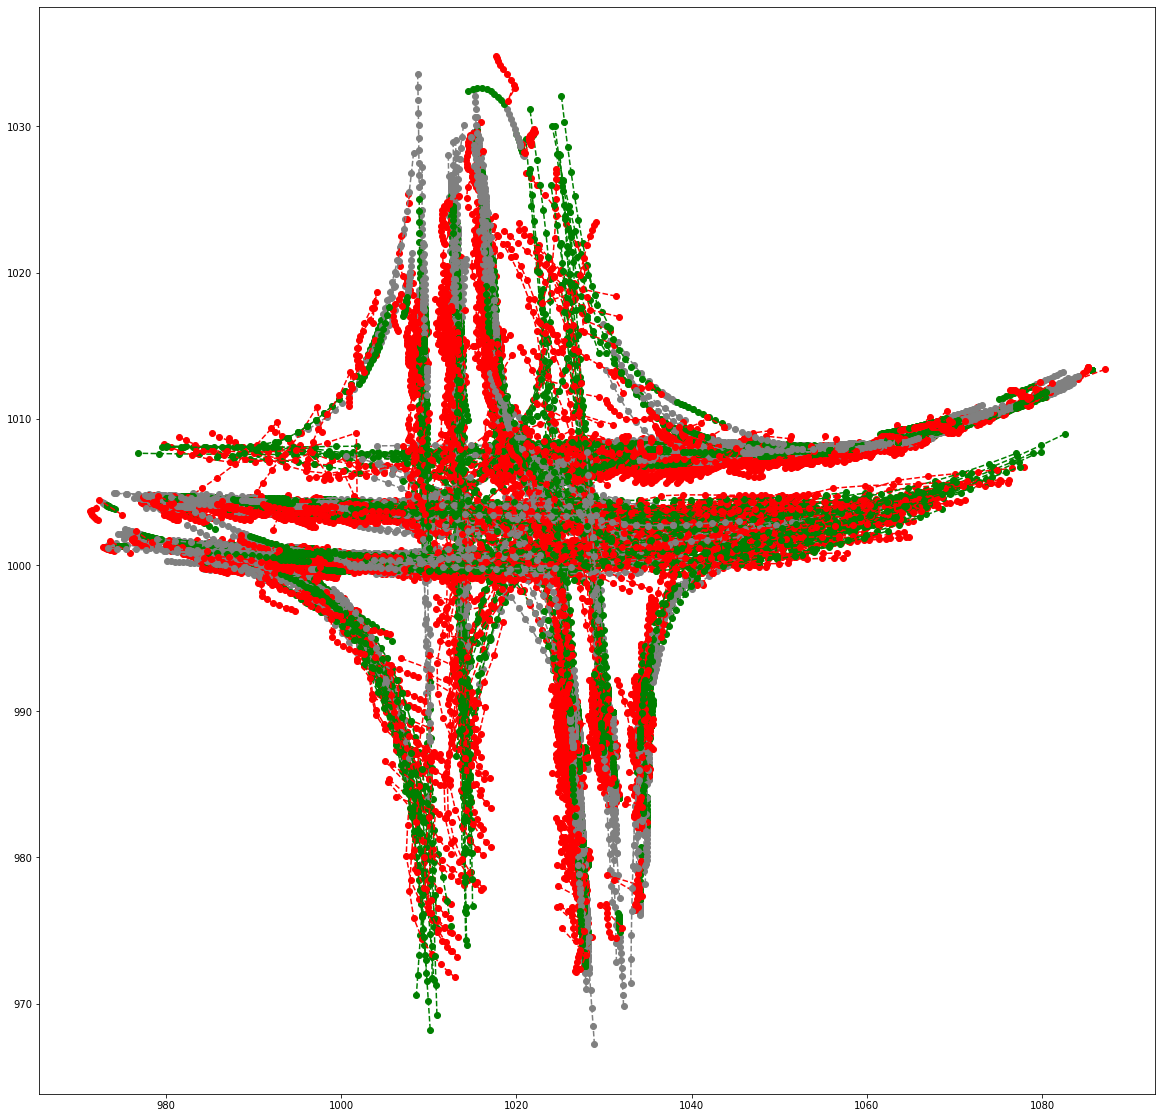

In [ ]:
print_all_intersection(reversed_scene_x_test,reversed_scene_y_test,reversed_results,len(reversed_scene_x_test),0)

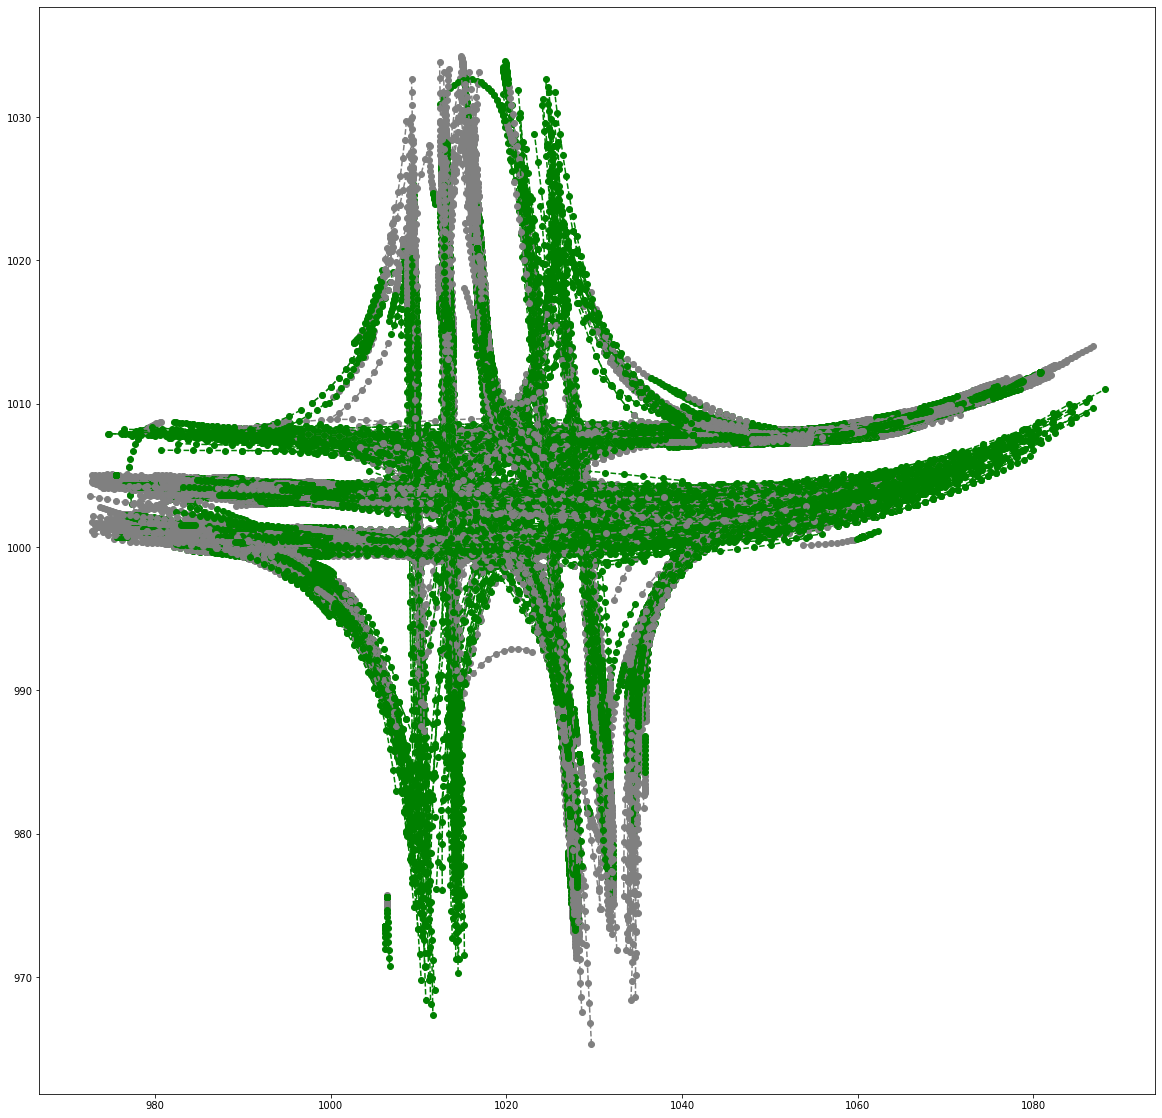

In [ ]:
print_all_intersection(reversed_scene_x_train,reversed_scene_y_train,None,len(reversed_scene_x_train),0)

In [ ]:
# Function for performance report.
def performance_report(cm):
    col = len(cm)
      
    # col=number of class
    arr = []
    for key, value in cm.items():
        arr.append(value)
  
    cr = dict()
    support_sum = 0
      
    # macro avg of support is
    # sum of support only, not the mean.
    macro = [0]*3  
      
    # weighted avg of support is
    # sum of support only, not the mean.
    weighted = [0]*3
    for i in range(col):
        vertical_sum= sum([arr[j][i] for j in range(col)])
        horizontal_sum= sum(arr[i])
        p = arr[i][i] / vertical_sum
        r = arr[i][i] / horizontal_sum
        f = (2 * p * r) / (p + r)
        s = horizontal_sum
        row=[p,r,f,s]
        support_sum+=s
        for j in range(3):
            macro[j]+=row[j]
            weighted[j]+=row[j]*s
        cr[i]=row
  
    # add Accuracy parameters.
    truepos=0
    total=0
    for i in range(col):
        truepos+=arr[i][i]
        total+=sum(arr[i])
  
    cr['Accuracy']=["", "", truepos/total, support_sum]
  
    # Add macro-weight and weighted_avg features.
    macro_avg=[Sum/col for Sum in macro]
    macro_avg.append(support_sum)
    cr['Macro_avg']=macro_avg
  
    weighted_avg=[Sum/support_sum for Sum in weighted]
    weighted_avg.append(support_sum)
    cr['Weighted_avg']=weighted_avg
  
    # print the classification_report
    print("Performance report of the model is :")
    space,p,r,f,s=" ","Precision","Recall","F1-Score","Support"
    print("%13s %9s %9s %9s %9s\n"%(space,p,r,f,s))
    stop=0
    for key,value in cr.items():
        if stop<col:
            stop+=1
            print("%13s %9.2f %9.2f %9.2f %9d"%(key,value[0],
                                                value[1],
                                                value[2],
                                                value[3]))
        elif stop==col:
            stop+=1
            print("\n%13s %9s %9s %9.2f %9d"%(key,value[0],
                                              value[1],
                                              value[2],
                                              value[3]))
        else:
            print("%13s %9.2f %9.2f %9.2f %9d"%(key,
                                                value[0],
                                                value[1],
                                                value[2],
                                                value[3]))

In [ ]:
cm= [ 

[570, 17, 5],

[23, 290, 57],

[14, 14, 40]

]

cr=performance_report(cm)

AttributeError: ignored

In [ ]:
# Our aim is to build the function
# for calculating the confusion_matrix
# and classification_report
# for multiclass classification, like IRIS dataset.

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Function for confusion matrix
def Confusion_matrix(y_test, y_pred, target_names=None):
	
	# target_names is a list.
	# actual values are arranged in the rows.
	# predicted values are arranged in the columns.
	# if there are m classes, then cm is m*m matrix.
	if target_names == None:
		m = len(set(y_test))
	else:
		m = len(target_names)
	size = len(y_test)
	matrix = dict()

	# create matrix initialised with 0
	for class_name in range(m):
		matrix[class_name] = [0 for k in range(m)]

	# populating the matrix.
	for i in range(size):
		actual_class = y_test[i]
		pred_class = y_pred[i]
		matrix[actual_class][pred_class] += 1

	# Change the name of columns.
	if target_names == None:
		# Now, lets print the confusion matrix.
		print("Confusion Matrix of given model is :")
		if m == 3:
			print("Count=%-14d %-15s %-15s %-15s" % (size,
													'0', '1',
													'2'))
			for key, value in matrix.items():
				print("Actual %-13s %-15d %-15d %-15d" %
					(key, value[0], value[1], value[2]))
		elif m == 2:
			print("Count=%-14d %-15s %-15s" % (size, '0', '1'))
			for key, value in matrix.items():
				print("Actual %-13s %-15d %-15d" % (key, value[0],
													value[1]))
	else:
		matrix = dict(zip(target_names, list(matrix.values())))

		# Now, lets print the confusion matrix.
		print("Confusion Matrix of given model is :")
		print("Count=%-14d %-15s %-15s %-15s" %
			(size, target_names[0], target_names[1], target_names[2]))
		for key, value in matrix.items():
			print("Actual %-13s %-15d %-15d %-15d" %
				(key, value[0], value[1], value[2]))

	return matrix

# Function for performance report.
def performance_report(cm):
	col = len(cm)
	
	# col=number of class
	arr = []
	for key, value in cm.items():
		arr.append(value)

	cr = dict()
	support_sum = 0
	
	# macro avg of support is
	# sum of support only, not the mean.
	macro = [0]*3
	
	# weighted avg of support is
	# sum of support only, not the mean.
	weighted = [0]*3
	for i in range(col):
		vertical_sum= sum([arr[j][i] for j in range(col)])
		horizontal_sum= sum(arr[i])
		p = arr[i][i] / vertical_sum
		r = arr[i][i] / horizontal_sum
		f = (2 * p * r) / (p + r)
		s = horizontal_sum
		row=[p,r,f,s]
		support_sum+=s
		for j in range(3):
			macro[j]+=row[j]
			weighted[j]+=row[j]*s
		cr[i]=row

	# add Accuracy parameters.
	truepos=0
	total=0
	for i in range(col):
		truepos+=arr[i][i]
		total+=sum(arr[i])

	cr['Accuracy']=["", "", truepos/total, support_sum]

	# Add macro-weight and weighted_avg features.
	macro_avg=[Sum/col for Sum in macro]
	macro_avg.append(support_sum)
	cr['Macro_avg']=macro_avg

	weighted_avg=[Sum/support_sum for Sum in weighted]
	weighted_avg.append(support_sum)
	cr['Weighted_avg']=weighted_avg

	# print the classification_report
	print("Performance report of the model is :")
	space,p,r,f,s=" ","Precision","Recall","F1-Score","Support"
	print("%13s %9s %9s %9s %9s\n"%(space,p,r,f,s))
	stop=0
	for key,value in cr.items():
		if stop<col:
			stop+=1
			print("%13s %9.2f %9.2f %9.2f %9d"%(key,value[0],
												value[1],
												value[2],
												value[3]))
		elif stop==col:
			stop+=1
			print("\n%13s %9s %9s %9.2f %9d"%(key,value[0],
											value[1],
											value[2],
											value[3]))
		else:
			print("%13s %9.2f %9.2f %9.2f %9d"%(key,
												value[0],
												value[1],
												value[2],
												value[3]))

# from sklearn.metrics import
# confusion_matrix,classification_report
# Main Function is here.

	dataset=load_iris()
	X,y,classes=dataset['data'],dataset['target'],
	dataset['target_names']

	X_train,X_test,y_train,y_test=train_test_split(
	X,y,shuffle=True,random_state=5,test_size=0.3)
	
	model=GaussianNB().fit(X_train,y_train)
	y_pred=model.predict(X_test)
	classes=list(classes)
	cm=Confusion_matrix(y_test, y_pred, classes)
	cr=performance_report(cm)
	print("\nCR by library method=\n",
		classification_report(y_test, y_pred))


